<a href="https://colab.research.google.com/github/AMEERKOTTA/hands_on_machine_learning_with_sklearn_keras_and_tensorflow/blob/main/Intro%20to%20Tensorflow%20for%20Deep%20Learning/07-Time%20Series%20Forecasting/06_forecasting_using_simple_rnn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FORECASTING USING SIMPLE RNN MODEL**


IMPORT LIBRARIES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

USEFUL FUNCTIONS

In [19]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  
  
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

PREPARE THE SEQUENCE

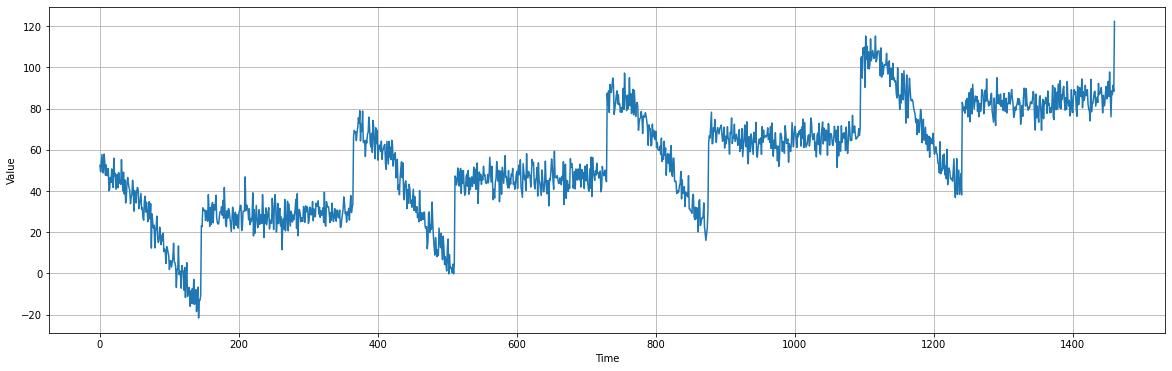

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(20, 6))
plot_series(time, series)
plt.show()

In [4]:
## split the dataset
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

SIMPLE RNN FORECASTING - SEQUENCE TO VECTOR MODEL

In [6]:
window_size = 30
## preparing the train set.
train_set = window_dataset(x_train, window_size, batch_size=128)

## build the simpleRNN model
## sequence to vector model.
## in only one simple RNN layer "return_sequences = True" implemented
model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

## define teh learning rate scheduler
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
## defne the optmizer
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
## compile the model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
## train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 3s 71ms/step - loss: 14.2462 - mae: 14.7334 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 38ms/step - loss: 13.4572 - mae: 13.9447 - lr: 1.1220e-07
Epoch 3/100
8/8 [==============================] - 0s 41ms/step - loss: 12.6167 - mae: 13.1003 - lr: 1.2589e-07
Epoch 4/100
8/8 [==============================] - 0s 41ms/step - loss: 12.1856 - mae: 12.6724 - lr: 1.4125e-07
Epoch 5/100
8/8 [==============================] - 0s 39ms/step - loss: 11.9017 - mae: 12.3868 - lr: 1.5849e-07
Epoch 6/100
8/8 [==============================] - 0s 39ms/step - loss: 11.7072 - mae: 12.1946 - lr: 1.7783e-07
Epoch 7/100
8/8 [==============================] - 0s 42ms/step - loss: 11.4584 - mae: 11.9400 - lr: 1.9953e-07
Epoch 8/100
8/8 [==============================] - 0s 42ms/step - loss: 11.1887 - mae: 11.6742 - lr: 2.2387e-07
Epoch 9/100
8/8 [==============================] - 0s 39ms/step - loss: 10.9547 - mae: 11.4402 - lr: 2.5

(1e-07, 0.0001, 0.0, 30.0)

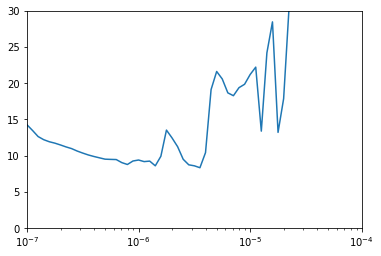

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

Here the Learning Rate of 1e-6 could be the Best Option looking at the Graph.

In [12]:
## Doing the Same thing Again
## here using model check point ans early stopping as well.

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(learning_rate=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)
history = model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
      8/Unknown - 4s 76ms/step - loss: 26.4391 - mae: 26.9368

8/8 [==============================] - 9s 743ms/step - loss: 26.4391 - mae: 26.9368 - val_loss: 22.8671 - val_mae: 23.3630
Epoch 2/500
8/8 [==============================] - ETA: 0s - loss: 17.8092 - mae: 18.2994

8/8 [==============================] - 5s 757ms/step - loss: 17.8092 - mae: 18.2994 - val_loss: 20.4223 - val_mae: 20.9188
Epoch 3/500
8/8 [==============================] - 1s 64ms/step - loss: 14.2176 - mae: 14.7108 - val_loss: 23.1112 - val_mae: 23.6101
Epoch 4/500
8/8 [==============================] - 1s 63ms/step - loss: 11.9995 - mae: 12.4917 - val_loss: 24.0897 - val_mae: 24.5869
Epoch 5/500
7/8 [=========================>....] - ETA: 0s - loss: 10.9361 - mae: 11.4249

8/8 [==============================] - 6s 828ms/step - loss: 10.9216 - mae: 11.4106 - val_loss: 19.4690 - val_mae: 19.9673
Epoch 6/500
7/8 [=========================>....] - ETA: 0s - loss: 10.2342 - mae: 10.7233

8/8 [==============================] - 5s 664ms/step - loss: 10.1037 - mae: 10.5921 - val_loss: 15.4995 - val_mae: 15.9932
Epoch 7/500
8/8 [==============================] - ETA: 0s - loss: 9.4930 - mae: 9.9810

8/8 [==============================] - 6s 786ms/step - loss: 9.4930 - mae: 9.9810 - val_loss: 15.2157 - val_mae: 15.7104
Epoch 8/500
8/8 [==============================] - 1s 63ms/step - loss: 9.1353 - mae: 9.6192 - val_loss: 15.4713 - val_mae: 15.9667
Epoch 9/500
8/8 [==============================] - ETA: 0s - loss: 8.5403 - mae: 9.0235

8/8 [==============================] - 5s 754ms/step - loss: 8.5403 - mae: 9.0235 - val_loss: 12.7334 - val_mae: 13.2261
Epoch 10/500
7/8 [=========================>....] - ETA: 0s - loss: 8.2699 - mae: 8.7557

8/8 [==============================] - 5s 746ms/step - loss: 8.0657 - mae: 8.5519 - val_loss: 10.7488 - val_mae: 11.2401
Epoch 11/500
8/8 [==============================] - 1s 66ms/step - loss: 7.9196 - mae: 8.4021 - val_loss: 12.5894 - val_mae: 13.0800
Epoch 12/500
8/8 [==============================] - 1s 69ms/step - loss: 7.8903 - mae: 8.3726 - val_loss: 12.5847 - val_mae: 13.0754
Epoch 13/500
7/8 [=========================>....] - ETA: 0s - loss: 7.6618 - mae: 8.1451

8/8 [==============================] - 6s 825ms/step - loss: 7.5818 - mae: 8.0648 - val_loss: 8.5347 - val_mae: 9.0240
Epoch 14/500
8/8 [==============================] - 1s 66ms/step - loss: 7.3399 - mae: 7.8224 - val_loss: 9.0902 - val_mae: 9.5814
Epoch 15/500
8/8 [==============================] - 1s 69ms/step - loss: 7.1304 - mae: 7.6117 - val_loss: 10.3061 - val_mae: 10.7971
Epoch 16/500
8/8 [==============================] - 1s 69ms/step - loss: 7.0900 - mae: 7.5712 - val_loss: 8.8385 - val_mae: 9.3323
Epoch 17/500
7/8 [=========================>....] - ETA: 0s - loss: 7.3202 - mae: 7.8047

8/8 [==============================] - 5s 623ms/step - loss: 7.1706 - mae: 7.6551 - val_loss: 6.6627 - val_mae: 7.1461
Epoch 18/500
8/8 [==============================] - 1s 63ms/step - loss: 7.0868 - mae: 7.5679 - val_loss: 9.6867 - val_mae: 10.1793
Epoch 19/500
8/8 [==============================] - ETA: 0s - loss: 7.0571 - mae: 7.5383

8/8 [==============================] - 6s 777ms/step - loss: 7.0571 - mae: 7.5383 - val_loss: 6.0547 - val_mae: 6.5333
Epoch 20/500
8/8 [==============================] - 1s 64ms/step - loss: 7.1291 - mae: 7.6074 - val_loss: 6.7998 - val_mae: 7.2873
Epoch 21/500
8/8 [==============================] - 1s 63ms/step - loss: 6.6039 - mae: 7.0837 - val_loss: 6.8184 - val_mae: 7.3053
Epoch 22/500
7/8 [=========================>....] - ETA: 0s - loss: 6.2785 - mae: 6.7624

8/8 [==============================] - 5s 640ms/step - loss: 6.4830 - mae: 6.9665 - val_loss: 5.9857 - val_mae: 6.4639
Epoch 23/500
8/8 [==============================] - 1s 104ms/step - loss: 6.5222 - mae: 7.0029 - val_loss: 6.2611 - val_mae: 6.7462
Epoch 24/500
8/8 [==============================] - 1s 123ms/step - loss: 6.5825 - mae: 7.0616 - val_loss: 8.1650 - val_mae: 8.6477
Epoch 25/500
8/8 [==============================] - 1s 63ms/step - loss: 6.4427 - mae: 6.9311 - val_loss: 6.3503 - val_mae: 6.8342
Epoch 26/500
8/8 [==============================] - 1s 65ms/step - loss: 6.3475 - mae: 6.8250 - val_loss: 6.9113 - val_mae: 7.3976
Epoch 27/500
8/8 [==============================] - 1s 63ms/step - loss: 6.1769 - mae: 6.6566 - val_loss: 6.3754 - val_mae: 6.8595
Epoch 28/500
8/8 [==============================] - 1s 66ms/step - loss: 6.0869 - mae: 6.5663 - val_loss: 6.2610 - val_mae: 6.7436
Epoch 29/500
7/8 [=========================>....] - ETA: 0s - loss: 5.9302 - mae: 6.4112

8/8 [==============================] - 5s 701ms/step - loss: 6.0244 - mae: 6.5041 - val_loss: 5.4015 - val_mae: 5.8770
Epoch 30/500
8/8 [==============================] - 1s 96ms/step - loss: 6.2320 - mae: 6.7096 - val_loss: 7.2208 - val_mae: 7.7047
Epoch 31/500
8/8 [==============================] - 1s 123ms/step - loss: 5.9625 - mae: 6.4451 - val_loss: 5.5351 - val_mae: 6.0161
Epoch 32/500
8/8 [==============================] - 1s 64ms/step - loss: 5.8776 - mae: 6.3533 - val_loss: 5.4115 - val_mae: 5.8915
Epoch 33/500
8/8 [==============================] - 1s 66ms/step - loss: 5.9428 - mae: 6.4248 - val_loss: 7.6437 - val_mae: 8.1260
Epoch 34/500
8/8 [==============================] - 1s 69ms/step - loss: 5.9457 - mae: 6.4234 - val_loss: 5.4989 - val_mae: 5.9813
Epoch 35/500
8/8 [==============================] - 1s 65ms/step - loss: 5.7387 - mae: 6.2143 - val_loss: 5.6398 - val_mae: 6.1201
Epoch 36/500
8/8 [==============================] - ETA: 0s - loss: 5.6891 - mae: 6.1715

8/8 [==============================] - 5s 642ms/step - loss: 5.6891 - mae: 6.1715 - val_loss: 5.2010 - val_mae: 5.6782
Epoch 37/500
8/8 [==============================] - 1s 70ms/step - loss: 5.8268 - mae: 6.3050 - val_loss: 7.3814 - val_mae: 7.8661
Epoch 38/500
8/8 [==============================] - 1s 63ms/step - loss: 6.1943 - mae: 6.6757 - val_loss: 5.2688 - val_mae: 5.7541
Epoch 39/500
8/8 [==============================] - 1s 121ms/step - loss: 5.9921 - mae: 6.4715 - val_loss: 8.4727 - val_mae: 8.9630
Epoch 40/500
8/8 [==============================] - 1s 125ms/step - loss: 6.0263 - mae: 6.5057 - val_loss: 5.2029 - val_mae: 5.6863
Epoch 41/500
8/8 [==============================] - 1s 67ms/step - loss: 5.8198 - mae: 6.3001 - val_loss: 6.8683 - val_mae: 7.3511
Epoch 42/500
8/8 [==============================] - 1s 63ms/step - loss: 5.7649 - mae: 6.2439 - val_loss: 5.2611 - val_mae: 5.7459
Epoch 43/500
8/8 [==============================] - 1s 67ms/step - loss: 5.6788 - mae: 6.1604

8/8 [==============================] - 5s 636ms/step - loss: 5.4264 - mae: 5.9045 - val_loss: 5.1369 - val_mae: 5.6135
Epoch 46/500
8/8 [==============================] - 1s 67ms/step - loss: 5.5082 - mae: 5.9871 - val_loss: 6.3405 - val_mae: 6.8224
Epoch 47/500
8/8 [==============================] - 1s 64ms/step - loss: 5.4473 - mae: 5.9269 - val_loss: 5.1428 - val_mae: 5.6278
Epoch 48/500
8/8 [==============================] - 1s 118ms/step - loss: 5.4540 - mae: 5.9302 - val_loss: 5.2768 - val_mae: 5.7576
Epoch 49/500
8/8 [==============================] - 1s 121ms/step - loss: 5.3657 - mae: 5.8417 - val_loss: 6.7446 - val_mae: 7.2281
Epoch 50/500
7/8 [=========================>....] - ETA: 0s - loss: 5.4215 - mae: 5.8987

8/8 [==============================] - 5s 734ms/step - loss: 5.3996 - mae: 5.8778 - val_loss: 5.0472 - val_mae: 5.5227
Epoch 51/500
8/8 [==============================] - 1s 69ms/step - loss: 5.4701 - mae: 5.9501 - val_loss: 6.7138 - val_mae: 7.1977
Epoch 52/500
8/8 [==============================] - 1s 66ms/step - loss: 5.6213 - mae: 6.0998 - val_loss: 5.3560 - val_mae: 5.8351
Epoch 53/500
8/8 [==============================] - 1s 66ms/step - loss: 5.9379 - mae: 6.4186 - val_loss: 5.4334 - val_mae: 5.9128
Epoch 54/500
8/8 [==============================] - 1s 67ms/step - loss: 5.6256 - mae: 6.1065 - val_loss: 5.5691 - val_mae: 6.0477
Epoch 55/500
8/8 [==============================] - 1s 67ms/step - loss: 5.5042 - mae: 5.9806 - val_loss: 5.0685 - val_mae: 5.5440
Epoch 56/500
8/8 [==============================] - 1s 119ms/step - loss: 5.3485 - mae: 5.8281 - val_loss: 6.2033 - val_mae: 6.6865
Epoch 57/500
8/8 [==============================] - 1s 121ms/step - loss: 5.2036 - mae: 5.6812

8/8 [==============================] - 5s 629ms/step - loss: 5.1984 - mae: 5.6784 - val_loss: 5.0298 - val_mae: 5.5040
Epoch 60/500
8/8 [==============================] - 1s 68ms/step - loss: 5.0864 - mae: 5.5641 - val_loss: 7.2142 - val_mae: 7.7001
Epoch 61/500
8/8 [==============================] - ETA: 0s - loss: 5.2870 - mae: 5.7652

8/8 [==============================] - 5s 754ms/step - loss: 5.2870 - mae: 5.7652 - val_loss: 5.0136 - val_mae: 5.4882
Epoch 62/500
8/8 [==============================] - 1s 64ms/step - loss: 5.4511 - mae: 5.9307 - val_loss: 6.7692 - val_mae: 7.2553
Epoch 63/500
8/8 [==============================] - 1s 64ms/step - loss: 5.6424 - mae: 6.1239 - val_loss: 5.2416 - val_mae: 5.7198
Epoch 64/500
8/8 [==============================] - 1s 64ms/step - loss: 5.7957 - mae: 6.2774 - val_loss: 5.1587 - val_mae: 5.6419
Epoch 65/500
8/8 [==============================] - 1s 64ms/step - loss: 5.8499 - mae: 6.3333 - val_loss: 7.4593 - val_mae: 7.9480
Epoch 66/500
7/8 [=========================>....] - ETA: 0s - loss: 5.2376 - mae: 5.7194

8/8 [==============================] - 6s 836ms/step - loss: 5.2156 - mae: 5.6967 - val_loss: 4.9930 - val_mae: 5.4658
Epoch 67/500
8/8 [==============================] - 1s 67ms/step - loss: 5.1404 - mae: 5.6176 - val_loss: 5.6902 - val_mae: 6.1676
Epoch 68/500
8/8 [==============================] - 1s 69ms/step - loss: 5.3261 - mae: 5.8044 - val_loss: 6.8328 - val_mae: 7.3179
Epoch 69/500
8/8 [==============================] - 1s 67ms/step - loss: 5.6433 - mae: 6.1255 - val_loss: 5.0039 - val_mae: 5.4771
Epoch 70/500
8/8 [==============================] - 1s 101ms/step - loss: 5.3542 - mae: 5.8278 - val_loss: 6.9840 - val_mae: 7.4709
Epoch 71/500
8/8 [==============================] - 1s 120ms/step - loss: 5.1275 - mae: 5.6051 - val_loss: 5.0141 - val_mae: 5.4887
Epoch 72/500
8/8 [==============================] - 1s 71ms/step - loss: 5.1096 - mae: 5.5866 - val_loss: 6.2426 - val_mae: 6.7248
Epoch 73/500
8/8 [==============================] - 1s 71ms/step - loss: 5.1381 - mae: 5.6158

8/8 [==============================] - 5s 697ms/step - loss: 4.9842 - mae: 5.4619 - val_loss: 4.9808 - val_mae: 5.4563
Epoch 80/500
8/8 [==============================] - 1s 120ms/step - loss: 4.9630 - mae: 5.4418 - val_loss: 6.5235 - val_mae: 7.0058
Epoch 81/500
7/8 [=========================>....] - ETA: 0s - loss: 4.8493 - mae: 5.3264

8/8 [==============================] - 5s 737ms/step - loss: 4.9188 - mae: 5.3968 - val_loss: 4.9709 - val_mae: 5.4466
Epoch 82/500
8/8 [==============================] - 1s 72ms/step - loss: 4.9629 - mae: 5.4394 - val_loss: 6.0979 - val_mae: 6.5779
Epoch 83/500
8/8 [==============================] - 1s 68ms/step - loss: 4.7958 - mae: 5.2730 - val_loss: 5.2488 - val_mae: 5.7285
Epoch 84/500
8/8 [==============================] - 1s 66ms/step - loss: 4.8211 - mae: 5.2940 - val_loss: 6.4707 - val_mae: 6.9531
Epoch 85/500
8/8 [==============================] - 1s 67ms/step - loss: 4.8426 - mae: 5.3173 - val_loss: 5.0438 - val_mae: 5.5256
Epoch 86/500
8/8 [==============================] - 1s 61ms/step - loss: 4.7528 - mae: 5.2261 - val_loss: 6.0377 - val_mae: 6.5179
Epoch 87/500
8/8 [==============================] - 1s 92ms/step - loss: 5.0088 - mae: 5.4877 - val_loss: 5.0046 - val_mae: 5.4924
Epoch 88/500
8/8 [==============================] - 1s 124ms/step - loss: 5.1574 - mae: 5.6400 

8/8 [==============================] - 5s 632ms/step - loss: 4.8348 - mae: 5.3056 - val_loss: 4.9550 - val_mae: 5.4344
Epoch 91/500
8/8 [==============================] - 1s 72ms/step - loss: 5.0439 - mae: 5.5210 - val_loss: 6.9632 - val_mae: 7.4513
Epoch 92/500
7/8 [=========================>....] - ETA: 0s - loss: 4.9073 - mae: 5.3829

8/8 [==============================] - 5s 721ms/step - loss: 4.8918 - mae: 5.3663 - val_loss: 4.9299 - val_mae: 5.4052
Epoch 93/500
7/8 [=========================>....] - ETA: 0s - loss: 4.6083 - mae: 5.0833

8/8 [==============================] - 5s 724ms/step - loss: 4.7491 - mae: 5.2251 - val_loss: 4.9205 - val_mae: 5.3957
Epoch 94/500
8/8 [==============================] - 1s 111ms/step - loss: 5.0575 - mae: 5.5334 - val_loss: 6.6508 - val_mae: 7.1335
Epoch 95/500
8/8 [==============================] - 1s 109ms/step - loss: 5.4380 - mae: 5.9179 - val_loss: 5.8375 - val_mae: 6.3257
Epoch 96/500
8/8 [==============================] - 1s 120ms/step - loss: 5.4845 - mae: 5.9666 - val_loss: 7.9964 - val_mae: 8.4821
Epoch 97/500
8/8 [==============================] - 1s 67ms/step - loss: 5.0911 - mae: 5.5700 - val_loss: 5.0006 - val_mae: 5.4864
Epoch 98/500
8/8 [==============================] - 1s 68ms/step - loss: 4.8116 - mae: 5.2886 - val_loss: 4.9912 - val_mae: 5.4703
Epoch 99/500
8/8 [==============================] - 1s 68ms/step - loss: 4.8618 - mae: 5.3375 - val_loss: 6.9719 - val_mae: 7.4627
Epoch 100/500
8/8 [==============================] - 1s 66ms/step - loss: 4.7074 - mae: 5.18

8/8 [==============================] - 5s 632ms/step - loss: 4.5574 - mae: 5.0343 - val_loss: 4.9168 - val_mae: 5.3928
Epoch 113/500
8/8 [==============================] - 1s 65ms/step - loss: 4.5373 - mae: 5.0126 - val_loss: 5.6775 - val_mae: 6.1513
Epoch 114/500
7/8 [=========================>....] - ETA: 0s - loss: 4.6063 - mae: 5.0814

8/8 [==============================] - 6s 823ms/step - loss: 4.5566 - mae: 5.0323 - val_loss: 4.9015 - val_mae: 5.3774
Epoch 115/500
8/8 [==============================] - 1s 65ms/step - loss: 4.7373 - mae: 5.2153 - val_loss: 5.1640 - val_mae: 5.6417
Epoch 116/500
8/8 [==============================] - 1s 68ms/step - loss: 4.7618 - mae: 5.2400 - val_loss: 5.9380 - val_mae: 6.4161
Epoch 117/500
7/8 [=========================>....] - ETA: 0s - loss: 4.9231 - mae: 5.4010

8/8 [==============================] - 5s 749ms/step - loss: 4.8787 - mae: 5.3561 - val_loss: 4.9009 - val_mae: 5.3776
Epoch 118/500
8/8 [==============================] - 1s 68ms/step - loss: 4.9029 - mae: 5.3744 - val_loss: 6.6322 - val_mae: 7.1172
Epoch 119/500
8/8 [==============================] - 1s 65ms/step - loss: 4.7667 - mae: 5.2428 - val_loss: 4.9658 - val_mae: 5.4474
Epoch 120/500
8/8 [==============================] - 1s 69ms/step - loss: 4.7459 - mae: 5.2225 - val_loss: 5.3774 - val_mae: 5.8590
Epoch 121/500
8/8 [==============================] - 1s 64ms/step - loss: 4.6487 - mae: 5.1256 - val_loss: 5.6305 - val_mae: 6.1058
Epoch 122/500
8/8 [==============================] - 1s 92ms/step - loss: 4.4920 - mae: 4.9665 - val_loss: 5.2143 - val_mae: 5.6939
Epoch 123/500
8/8 [==============================] - 1s 69ms/step - loss: 4.6561 - mae: 5.1323 - val_loss: 5.2508 - val_mae: 5.7318
Epoch 124/500
8/8 [==============================] - 1s 123ms/step - loss: 4.5856 - mae: 

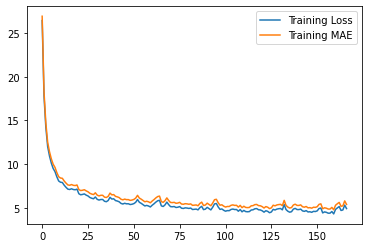

In [13]:
plt.plot(history.history["loss"], label = "Training Loss")
plt.plot(history.history["mae"], label = "Training MAE")
plt.legend();
plt.show();

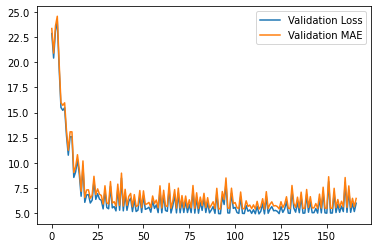

In [14]:
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.plot(history.history["val_mae"], label = "Validation MAE")
plt.legend();
plt.show();

In [15]:
model = keras.models.load_model("my_checkpoint")

In [16]:
## forecasting using model
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 1s 22ms/step


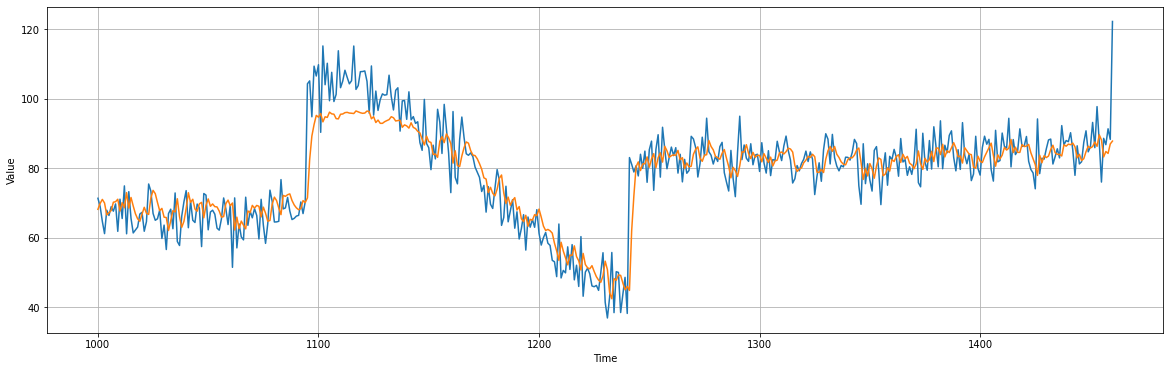

In [17]:
## plotting the rnn forecast
plt.figure(figsize=(20, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [18]:
## perfomance
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.3253617

`SEQUENCE TO VECTOR SIMPLE RNN MAE : 5.3`

SEQUENCE TO SEQUENCE FORECSATING

In [20]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [21]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

print(X_batch.shape)
print(Y_batch.shape)

X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
(1, 3, 1)
(1, 3, 1)


MODEL

In [23]:
window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 3s 50ms/step - loss: 346.3543 - mae: 346.8542 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 1s 46ms/step - loss: 311.0163 - mae: 311.5163 - lr: 1.0798e-07
Epoch 3/100
8/8 [==============================] - 1s 46ms/step - loss: 255.7891 - mae: 256.2891 - lr: 1.1659e-07
Epoch 4/100
8/8 [==============================] - 0s 44ms/step - loss: 188.7899 - mae: 189.2898 - lr: 1.2589e-07
Epoch 5/100
8/8 [==============================] - 1s 45ms/step - loss: 111.1011 - mae: 111.6008 - lr: 1.3594e-07
Epoch 6/100
8/8 [==============================] - 1s 46ms/step - loss: 41.8473 - mae: 42.3451 - lr: 1.4678e-07
Epoch 7/100
8/8 [==============================] - 0s 44ms/step - loss: 45.2188 - mae: 45.7156 - lr: 1.5849e-07
Epoch 8/100
8/8 [==============================] - 1s 50ms/step - loss: 35.8831 - mae: 36.3808 - lr: 1.7113e-07
Epoch 9/100
8/8 [==============================] - 1s 45ms/step - loss: 32.1420 - mae: 32.6384

(1e-07, 0.0001, 0.0, 30.0)

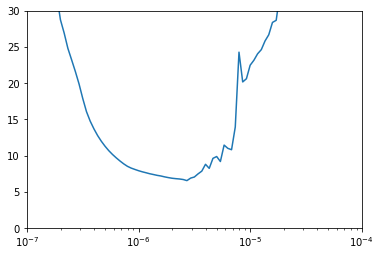

In [24]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

Best Learning Rate Could be between 1e-6 and 1e-5.

In [25]:
window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
history = model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 5s 155ms/step - loss: 122.8918 - mae: 123.3910 - val_loss: 98.6061 - val_mae: 99.1060
Epoch 2/500
8/8 [==============================] - 1s 65ms/step - loss: 80.0776 - mae: 80.5772 - val_loss: 80.1121 - val_mae: 80.6118
Epoch 3/500
8/8 [==============================] - 1s 69ms/step - loss: 45.9362 - mae: 46.4334 - val_loss: 24.3062 - val_mae: 24.8000
Epoch 4/500
8/8 [==============================] - 1s 68ms/step - loss: 37.1236 - mae: 37.6205 - val_loss: 48.6333 - val_mae: 49.1333
Epoch 5/500
8/8 [==============================] - 1s 67ms/step - loss: 29.0400 - mae: 29.5355 - val_loss: 24.7910 - val_mae: 25.2880
Epoch 6/500
8/8 [==============================] - 1s 62ms/step - loss: 23.3752 - mae: 23.8685 - val_loss: 17.9397 - val_mae: 18.4323
Epoch 7/500
8/8 [==============================] - 1s 65ms/step - loss: 20.3653 - mae: 20.8571 - val_loss: 18.4473 - val_mae: 18.9426
Epoch 8/500
8/8 [==============================] - 1s 68ms/

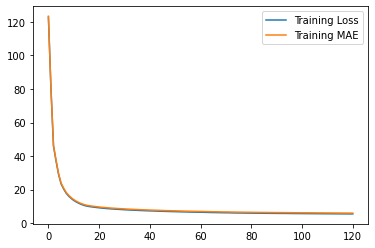

In [26]:
plt.plot(history.history["loss"], label = "Training Loss")
plt.plot(history.history["mae"], label = "Training MAE")
plt.legend();
plt.show();

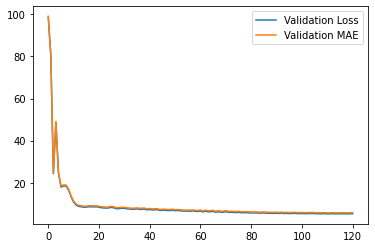

In [27]:
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.plot(history.history["val_mae"], label = "Validation MAE")
plt.legend();
plt.show();

In [28]:
## forecasting using the Model
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 1s 24ms/step


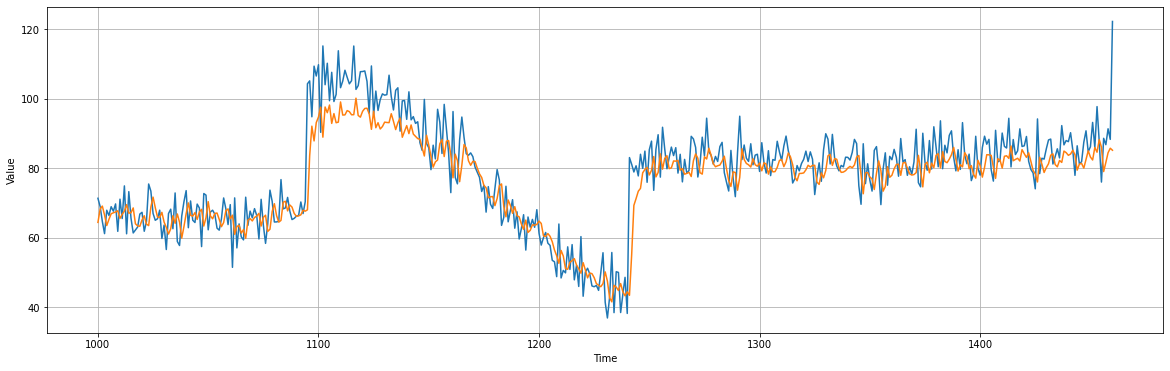

In [29]:
## plotting the result
plt.figure(figsize=(20, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [30]:
## perfomance
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.5267076

`Sequence to Sequence Simple RNN Model : 5.5`
****